<html>
 <head>
 </head>
 <body>
          <div class="alert alert-block alert-info" style="color:darkgreen;font-size:20px;text-align:center">
         <b>Large-scale deforestation monitoring with Sentinel 2 Using GEE </b>
     </div>
               <p style="text-align:center"> February 2023 </p>
     <br/>
     <a id='content'></a>
     <p style="color:blue"> <b>Contents:</b> </p>
     <a href="#1."> 1. Region of Interest (ROI)</a><br/>
     <a href="#2."> 2. Image collection of Sentinel-2 2018-2019</a><br/>
     <a href="#3."> 3. Forest/non-forest classification using Machine Learning</a><br/>
     <a href="#4."> 4. Detection of deforestation</a><br/>
     <br/>
     <p><b>NOTE</b></p>
     <p> &#x2022; This is just a demonstration of using GEE and machine Learning for deforestation detection</p>
     <p> &#x2022; The output is <b>not</b> mean to be used for legal or official deforestation mapping</p>
     <p> &#x2022; Despite simplicity of the algorithm, it satisfy the general workflow for deforestation detection</p>
     <p> &#x2022; In short, the python code extract Image collection within certain region and timeline, and determine if deforestation is taking place based on the change in land use class from forest to non-forest</p>
     <p> &#x2022; Google Earth Engine allows user to do spatial analysis in large dataset, but there is a size limitation when loading the spatial data into map canvas or transfering to local machine. Hence, only one region is used here for demonstration purpose</p>
     <br/>
     <p> &#x2022; <u>Hyperlink features</u> for table of content in Github <u>does not work</u> the same way in Jupyter Notebook. <b>Just scroll down !</b></p>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
          <a id='1.'></a>
     <p style="color:blue;font-size:20px"> 1. Region of Interest (ROI)</p>
     <br/>
     <p> &#x2022; The province of <b>West Celebes, Indonesia</b></p>
     <p> &#x2022; Geemap package is developed by <a href="https://github.com/giswqs/geemap"  target="_blank">Qiusheng Wu</a></p>
     <br/>
 </body>
</html>

In [3]:
import ee
import geemap

ee.Initialize()

import datetime
from datetime import date
import geemap.colormaps as cm

In [4]:
import geopandas as gpd

gdf = gpd.read_file('/your_shapefile.shp')
gdf['NAME_0']

0        South_Celebes
1         West_Celebes
2            Gorontalo
3        North_Celebes
4    Southeast_Celebes
5      Central_Celebes
Name: NAME_0, dtype: object

In [5]:
roi = geemap.geopandas_to_ee(gdf.loc[gdf['NAME_0'] == 'West_Celebes'])

In [35]:
Map=geemap.Map(center=[-2.402,119.389], zoom=8)

vis_params = {
    'color': 'red', 
    'width': 1,
    'lineType': 'solid',
    'fillColor': '00000000',
}
Map.addLayer(roi.style(**vis_params), {}, 'West Celebes', True)

Map

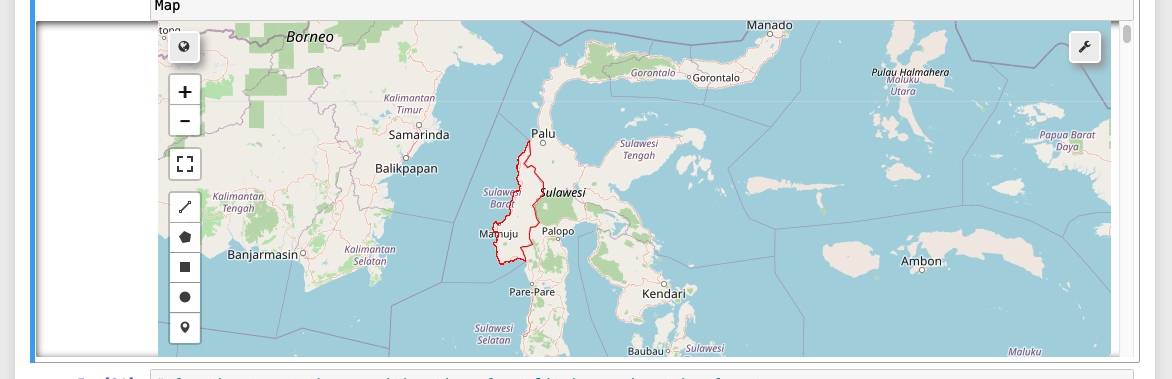

<html>
 <head>
 </head>
 <body>
          <a id='2.'></a>
     <p style="color:blue;font-size:20px"> 2. Image collection of Sentinel-2 2018-2019</p>
     <br/>
     <p> &#x2022; we select 2 years timeline, from January 2018 to December 2019</p>
     <p> &#x2022; if ROI is really big, you can resample to lower resolution for visualisation</p>
     <p> &#x2022; python code for cloud masking is from <a href="https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless"  target="_blank">here</a></p>
     <br/>
 </body>
</html>

In [21]:
def waktu_satelit(waktu):
    temp = datetime.datetime.fromtimestamp(waktu/1000).strftime('%Y-%m-%d')
    return(temp)

def days_number_b(tanggal):
    tanggal = tanggal.split('-')
    d0 = date(1970, 1, 1)
    d1 = date(int(tanggal[0]), int(tanggal[1]), int(tanggal[2]))
    delta = d1 - d0
    return(delta.days)

def clipcol(image):
    clipimage = image.clip(roi)
    return clipimage

def get_s2_sr_cld_col(aoi, start_date, end_date, s2_col = 'COPERNICUS/S2_SR'):
    s2_sr_col = (ee.ImageCollection(s2_col)
        .filterBounds(aoi).map(clipcol)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


def add_cloud_bands(img):
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    not_water = img.select('SCL').neq(6)

    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    img_cloud = add_cloud_bands(img)

    img_cloud_shadow = add_shadow_bands(img_cloud)

    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    not_cld_shdw = img.select('cloudmask').Not()

    return img.select('B.*').updateMask(not_cld_shdw)

def resample_SR(img):
    resampled_image = ee.Image(img.reproject(crs='EPSG:4326', scale=SR))
    return resampled_image


def VI_stack(img):
    ndvi = ee.Image(img.select('B8').subtract(img.select('B4')).\
        divide(img.select('B8').add(img.select('B4'))).rename('NDVI'))
    
    ndi45 = ee.Image(img.select('B5').subtract(img.select('B4')).\
        divide(img.select('B5').add(img.select('B4'))).rename('NDI45'))

    savi = ee.Image(img.expression(
        '((1 + L) * (NIR - RED) / (NIR + RED + L))', {
          'NIR': img.select('B8'),
          'RED': img.select('B4'),
            'L':0.428 
        }).rename('SAVI'))


    ndmi = ee.Image(img.select('B8').subtract(img.select('B11')).\
        divide(img.select('B8').add(img.select('B11'))).rename('NDMI'))
    
    doy = ee.Number(img.get('system:time_start')).divide(ee.Number(86400000))
    doyBand = ee.Image.constant(doy).uint16().rename('DOYY')
    doyBand = doyBand.updateMask(img.select('B8').mask())
    
    return img.addBands(ndvi).addBands(ndi45).addBands(savi).addBands(ndmi).addBands(doyBand)

In [22]:
CLOUD_FILTER = 30
SR = 50

CLOUD_FILTER = 30 
CLD_PRB_THRESH = 30 
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

Start_date = '2018-01-01'
End_date = '2019-12-31'

S2 = get_s2_sr_cld_col(roi, Start_date, End_date)
S2 = (S2.map(add_cld_shdw_mask).map(apply_cld_shdw_mask))

S2 = S2.map(resample_SR)

my_param = {'bands': ['B4',  'B3',  'B2'], 'max':1500}
Map.addLayer(S2.median(), my_param, 'Sentinel-2')

<html>
 <head>
 </head>
 <body>
     <p style="color:blue;font-size:15px"> collecting training data</p>
     <p>&#x2022; Store the RGB image to local machine, and lest do the forest/non-forest classification for training data in Desktop QGIS. It is more convenient to do it manually in Desktop QGIS</p>
     <p>&#x2022;  This is just for training data so export smaller subset. GEE has size limitation when importing raste to local machine</p>
     <p>&#x2022;  Disable pop-up window when making new feature in QGIS: "Settings" -> "Options" -> "Digitizing" and tick "Suppress attribute form pop-up after feature creation"</p>
     <br/>
 </body>
</html>

In [ ]:
fname = "temp_RGB.tif"

geemap.ee_export_image(S2.select(['B4',  'B3',  'B2']).median(), 
                       filename= fname, region = roi.geometry(),
                       scale = 50, file_per_band=False,
                       crs = 'EPSG:4326')

The white points are obviously forest. Assign the forest/non-forest class manually for each point

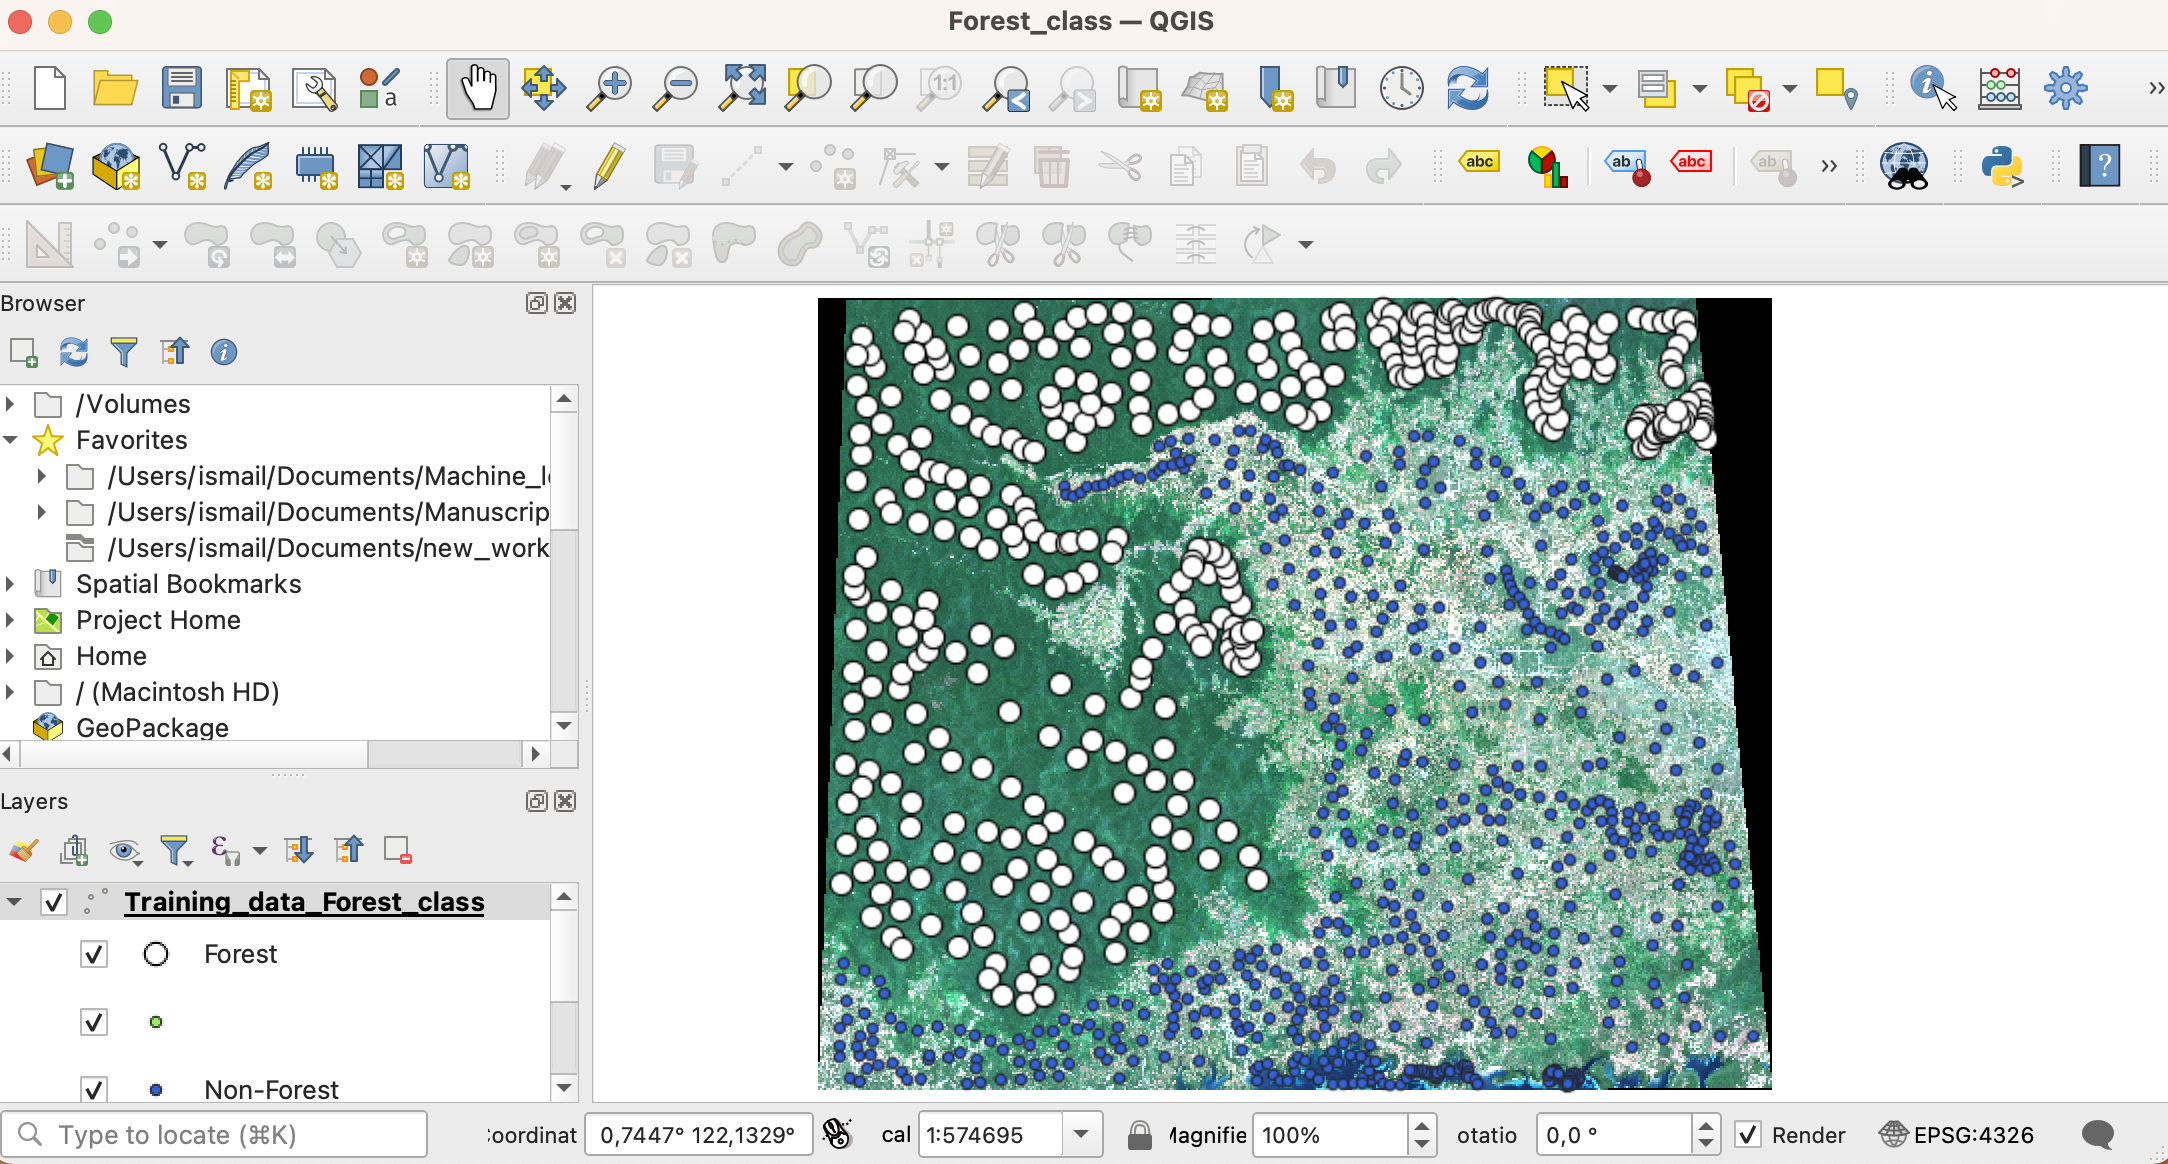

<html>
 <head>
 </head>
 <body>
     <p>&#x2022; we traine the model with Vegetation indices (NDVI, NDI45, SAVI, and NDMI) instead of the original Sentinel-2 bands</p>
     <p>&#x2022; however, we do not need to store the VIs into local machine, because we can extract the VI for each point in Geemap</p>
     <br/>
 </body>
</html>

In [29]:
S2 = (S2.map(VI_stack))
S2 = S2.select(['NDVI', 'NDI45', 'SAVI', 'NDMI', 'DOYY'])

Extract the VI values for each point in training data. Outpus is new shapefile

In [ ]:
in_fc = geemap.shp_to_ee('/Training_data_Forest_class.shp')
out_shp = '/Training_data_Forest_class_VI.shp'
geemap.extract_values_to_points(in_fc, 
                                S2.select(['NDVI', 'NDI45', 'SAVI', 'NDMI']).median(), 
                                out_shp, scale=50)

In [23]:
gdf = gpd.read_file('/Training_data_Forest_class_VI.shp')
gdf.head()

NDMI  LC      SAVI Land_cover      NDVI     NDI45  \
0  0.360492   1  1.237190     Forest  0.866470  0.549111   
1  0.353975   1  1.245676     Forest  0.872439  0.552206   
2  0.375771   1  1.233772     Forest  0.864071  0.525039   
3  0.314309   1  1.221472     Forest  0.855475  0.542511   
4  0.339832   1  1.240564     Forest  0.868844  0.558257   

                    geometry  
0  POINT (122.21498 0.84995)  
1  POINT (122.23391 0.84810)  
2  POINT (122.22052 0.83625)  
3  POINT (122.23391 0.83271)  
4  POINT (122.24330 0.83902)

Lets inspect the associated values of VI for forest/non-forest class. You can use matplotlib package to create basic boxplot or plotly package for fancy chart

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
fig_NDVI_f = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Forest', 'NDVI'], 
                  fillcolor='#66CDAA', marker_color='#66CDAA',
                  line=dict(width=0.7),
                 name='NDVI forest')

fig_NDVI_nf = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Non-Forest', 'NDVI'], 
                  fillcolor='#FF7F50', marker_color='#FF7F50',
                  line=dict(width=0.7),
                 name='NDVI non-forest')

fig_NDI45_f = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Forest', 'NDI45'], 
                  fillcolor='#66CDAA', marker_color='#66CDAA',
                  line=dict(width=0.7),
                 name='NDI45 forest')

fig_NDI45_nf = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Non-Forest', 'NDI45'], 
                  fillcolor='#FF7F50', marker_color='#FF7F50',
                  line=dict(width=0.7),
                 name='NDI45 non-forest')

fig_SAVI_f = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Forest', 'SAVI'], 
                  fillcolor='#66CDAA', marker_color='#66CDAA',
                  line=dict(width=0.7),
                 name='SAVI forest')

fig_SAVI_nf = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Non-Forest', 'SAVI'], 
                  fillcolor='#FF7F50', marker_color='#FF7F50',
                  line=dict(width=0.7),
                 name='SAVI non-forest')

fig_NDMI_f = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Forest', 'NDMI'], 
                  fillcolor='#66CDAA', marker_color='#66CDAA',
                  line=dict(width=0.7),
                 name='NDMI forest')

fig_NDMI_nf = go.Box(y=gdf.loc[gdf['Land_cover'] == 'Non-Forest', 'NDMI'], 
                  fillcolor='#FF7F50', marker_color='#FF7F50',
                  line=dict(width=0.7),
                 name='NDMI non-forest')

fig = make_subplots(rows=1, cols=4, horizontal_spacing = 0.05)

fig.add_trace(fig_NDVI_f, row = 1, col = 1)
fig.add_trace(fig_NDVI_nf, row = 1, col = 1)

fig.add_trace(fig_NDI45_f, row = 1, col = 2)
fig.add_trace(fig_NDI45_nf, row = 1, col = 2)

fig.add_trace(fig_SAVI_f, row = 1, col = 3)
fig.add_trace(fig_SAVI_nf, row = 1, col = 3)

fig.add_trace(fig_NDMI_f, row = 1, col = 4)
fig.add_trace(fig_NDMI_nf, row = 1, col = 4)

fig.update_layout(
    yaxis_title="VI values",
    autosize=False,
    width=950,
    height=400
)

fig.show()

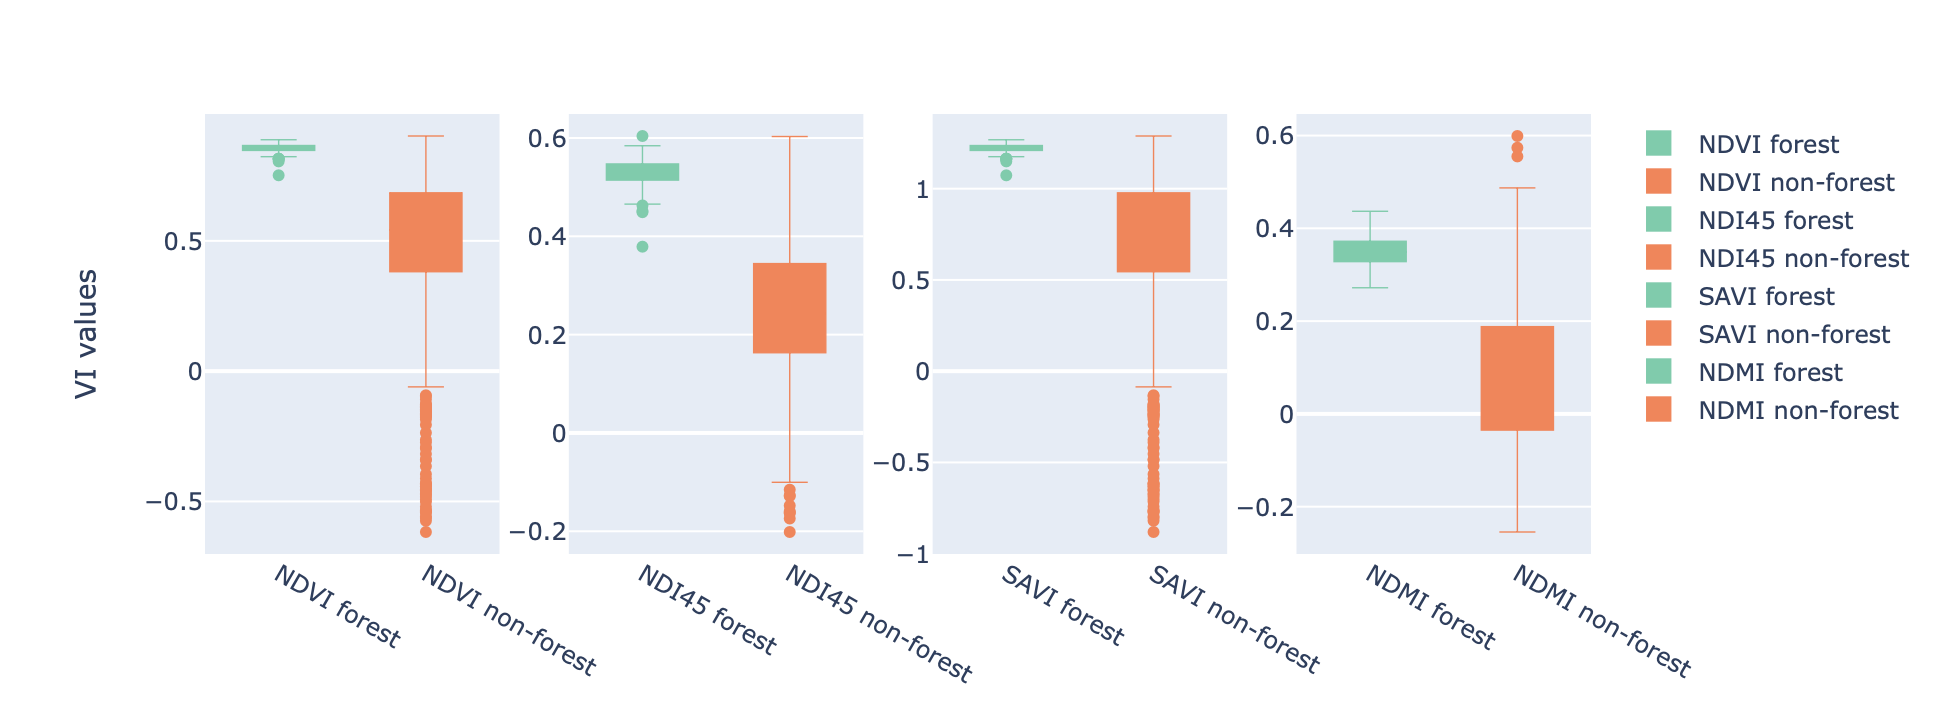

There are obvious contrast of VIs values between forest and non-forest. we can use this to help us separate forest class from non-forest land use/land cover

<html>
 <head>
 </head>
 <body>
          <a id='3.'></a>
     <p style="color:blue;font-size:20px"> 3. Forest/Non-forest classification with machine Learning</p>
     <br/>
     <p> &#x2022; there are several otpion for classifier available in GEE, with random forest as one of the most popular</p>
     <br/>
 </body>
</html>

<html>
 <head>
 </head>
 <body>
     <br/>
     <p  style="color:blue">3.a Option 1: Random forest classifier</p>
     <p></p>
     <br/>
 </body>
</html>

In [10]:
# get the coordinates
gdf['lon']  = gdf.geometry.x
gdf['lat']  = gdf.geometry.y

# import points and the attributes
features = [ee.Feature(ee.Geometry.Point(row['lon'], row['lat'])) 
                   .set('LC', row['LC'])
            .set('NDVI', row['NDVI'])
            .set('NDI45', row['NDI45'])
            .set('SAVI', row['SAVI'])
            .set('NDMI', row['NDMI']) for i,row in gdf.iterrows()]
fromList = ee.FeatureCollection(features)

In [11]:
fromList.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [122.2149809200353, 0.8499518378456193]},
 'id': '0',
 'properties': {'LC': 1,
  'NDI45': 0.549111306667328,
  'NDMI': 0.360492497682571,
  'NDVI': 0.866470277309418,
  'SAVI': 1.237189612873267}}

In [12]:
sample = fromList.randomColumn()

split = 0.9

training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))


ee_classifier = ee.Classifier.smileRandomForest(10).train(training, 'LC', ['NDI45', 'NDMI', 'NDVI', 'SAVI'])

Put the classifier inside a function so we can use the classifier for all image in Image collection

In [22]:
def ML_NF_class(img):
    
    FNF = ee.Image(img.classify(ee_classifier))
    NF = ee.Image(FNF.eq(0).rename('NF'))
    FC = ee.Image(FNF.eq(1).selfMask().rename('FC'))
    
    return img.addBands(NF).addBands(FC)

In [ ]:
S2 = (S2.map(ML_NF_class))

<html>
 <head>
 </head>
 <body>
     <br/>
     <p  style="color:blue">3.a Option 2: Simple Decision tree</p>
     <p> &#x2022; Unfortunately, the output from Random Forest classifier look so noisy. It seems the model is overfitting, as many forest is classified as non forest</p>
     <p> &#x2022; you can <b>tune the hyperparameters</b>, particulalry the number of tree, which was set as 10</p>
     <p> &#x2022; nevertheless, from inspecting the training data, the classification seems simple</p>
     <p> &#x2022; so let just create a simple decision tree for forest/non-forest classification</p>
     <br/>
 </body>
</html>

In [ ]:
def NF_class(img):
    
    NDVI_t = 0.75
    NDI45_t = 0.38
    SAVI_t = 1.07
    NDMI_t = 0.27
    
    NF = ee.Image(img.select('NDVI').lt(NDVI_t).\
                  And(img.select('NDI45').lt(NDI45_t)).\
                  And(img.select('SAVI').lt(SAVI_t)).\
                  And(img.select('NDMI').lt(NDMI_t)).rename('NF'))
    
    FC = ee.Image(img.select('NDVI').gte(NDVI_t).\
                  And(img.select('NDI45').gte(NDI45_t)).\
                  And(img.select('SAVI').gte(SAVI_t)).\
                  And(img.select('NDMI').gte(NDMI_t)).selfMask().rename('FC'))
    
    return img.addBands(NF).addBands(FC)

In [30]:
S2 = (S2.map(NF_class))

<html>
 <head>
 </head>
 <body>
          <a id='4.'></a>
     <p style="color:blue;font-size:20px"> 4. Detection of deforestation</p>
     <br/>
     <p> &#x2022; From classifier, we now have Image collection of forest/non-forest map from early 2018 to late 2019</p>
     <p> &#x2022; To determine, the timing of deforestation, we take the first time a pixel is classified as non-forest during the timeline</p>
     <p> &#x2022; hence, we have to remove any pixel with deforestation time is at the first acqusition date (e.g., 2018-01-01), because in this case, deforestation took place before our monitoring timeline, i.e., the pixel has been deforested beforehand</p>
     <p> &#x2022; to minimise the bias of deforestation detection because of forest/non-forest classification error, we set that pixel has been detected at least 3 times as forest beforehand to make sure that pixel indeed change from forest to non-forest</p>
<p> &#x2022; with these rules, it does not take into account if pixel is later change from non-forest to forest</p>
     <br/>
 </body>
</html>

In [31]:
def Def_time(img):
    
    def_map = ee.Image(img.select('NF').multiply(img.select('DOYY')).selfMask().rename('DT'))
    
    return img.addBands(def_map)

def finalise_deforestation(image):
    FT = image.select('DOYY').min()
    DT = image.select('DT').min()
    
    DT_Check = DT.gt(FT).selfMask().rename('DTC')
    DT_Check = DT_Check.select('DTC').multiply(DT).rename('DTC')
    
    NF_Check = image.select('NF').sum().gt(2).selfMask().rename('NFC')
    DT_Check = DT_Check.select('DTC').multiply(NF_Check).rename('DTC')
    
    FC_A = image.select('FC').sum().gt(2).selfMask().rename('FC_A')
    DT_Check = DT_Check.select('DTC').multiply(FC_A).rename('DTC')
    
    return DT_Check

In [32]:
S2 = (S2.map(Def_time))
S2_def = finalise_deforestation(S2)

In [34]:
palette = cm.get_palette('Reds', n_class=15)
param = {'min': days_number_b(Start_date), 'max': days_number_b(End_date), 'palette': palette}

Map.addLayer(S2_def, param, "Def. time")
Map.add_colorbar(param, label="deforestation day since 1970-01-01", layer_name="Def. time since 1970")

In [56]:
# accumulation of forest and nonforest
palette = cm.get_palette('Spectral', n_class=15)
Map.addLayer(S2.select('FC').sum(), {'min':1, 'max':20, 'palette': palette}, "F. Acu")
Map.add_colorbar({'min':1, 'max':20, 'palette': palette}, 
                 label="Forest accumulation", layer_name="FAC")

palette = cm.get_palette('RdYlGn', n_class=15)
Map.addLayer(S2.select('NF').sum(), {'min':1, 'max':20, 'palette': palette}, "NonF. Acu")
Map.add_colorbar({'min':1, 'max':20, 'palette': palette}, 
                 label="Non-Forest accumulation", layer_name="NFAC")

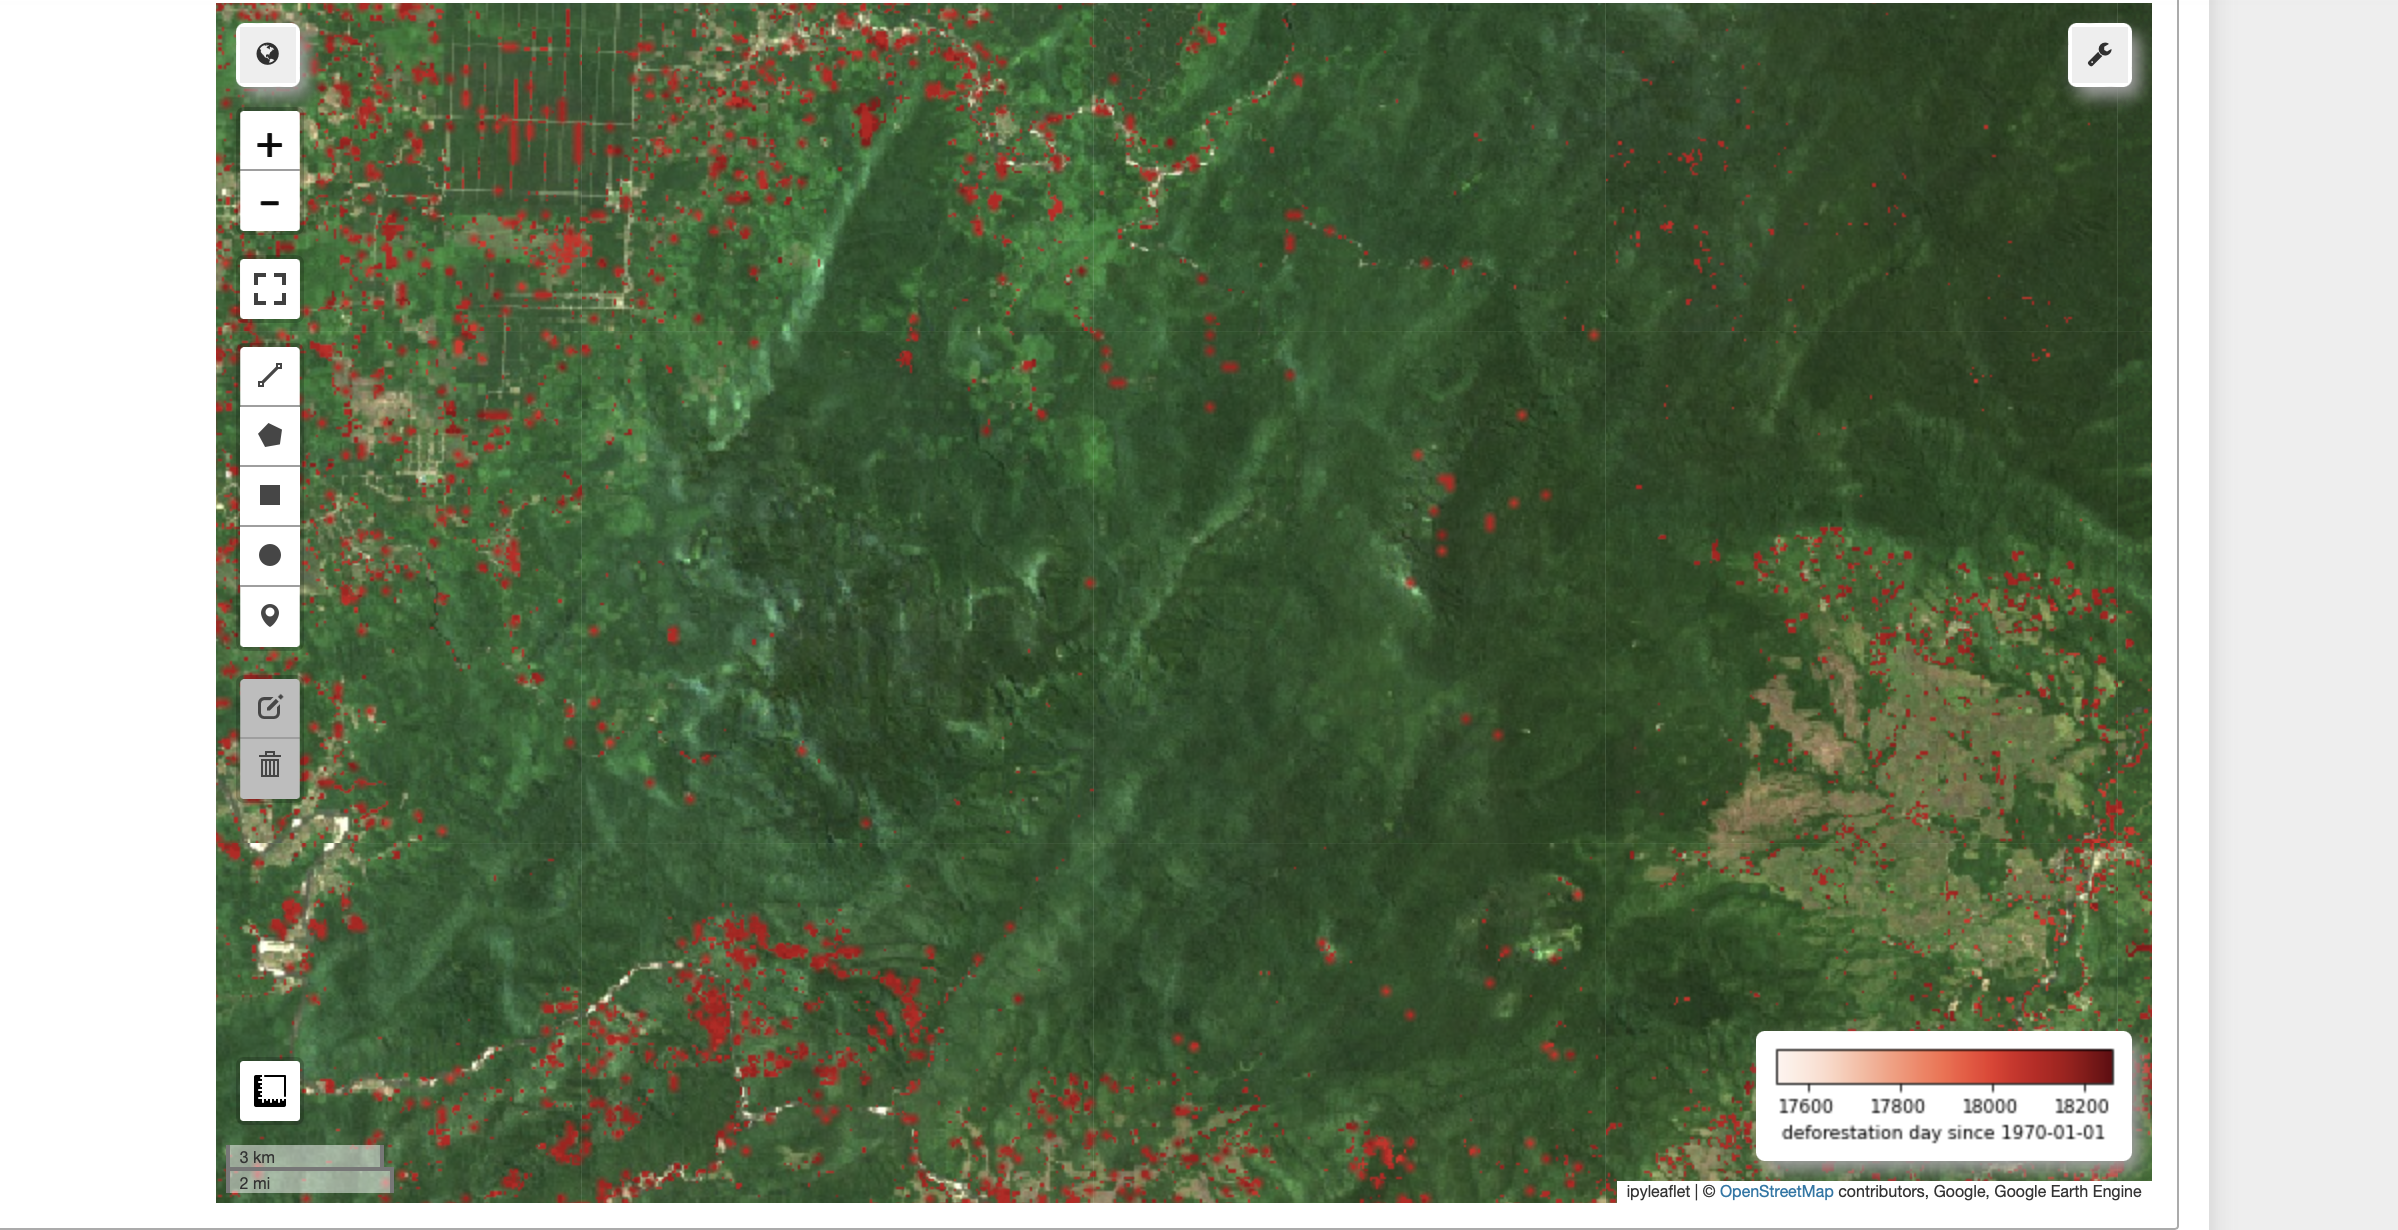

<html>
 <head>
 </head>
 <body>
     <p> &#x2022; If forest baseline available, the result can be finetuned later by filter out pixel within Non-forest area in the forest baseline</p>
     <p> &#x2022; The pixel value/DN represent when deforestation is taking place, represented as the number of day since 1970-01-01, </p>
     <br/>
 </body>
</html>